In [508]:
# data processing: 
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# modelling:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# plotting: 
import matplotlib.pyplot as plt

# VAR 
## U.S.
### Data collection
Determine timespan

In [510]:
start = datetime.datetime(2003, 1, 1)
end = datetime.datetime.today()

Upload data from FactSet:

In [512]:
FactSet = pd.read_excel("C:\\Users\\Asus\\Downloads\\PriceHistory.xlsx", header = 2)[1:].set_index('Date').resample('W').mean()
FactSet 

,Price,CVol,Change,% Change,"Total Return (Gross, Unhedged)","Cumulative Return % (Gross, Unhedged)",Open,High,Low,P/E - LTM
Date,,,,,,,,,,
2004-06-20,1135.015400,2.592532e+09,NaN,NaN,1669.390000,NaN,NaN,1139.08,1122.16,18.998112
2004-06-27,1134.432400,2.827884e+09,-0.583000,-0.051365,1668.929000,-0.027615,NaN,1146.34,1124.37,18.913275
2004-07-04,1125.379900,2.365324e+09,-9.052500,-0.797976,1656.331000,-0.782262,NaN,1144.22,1123.06,18.722237
2004-07-11,1112.811600,2.643733e+09,-12.568300,-1.116805,1638.419000,-1.855229,NaN,1125.38,1108.72,18.551909
2004-07-18,1101.394700,2.897508e+09,-11.416900,-1.025951,1621.806000,-2.850382,NaN,1119.60,1101.07,18.368180
...,...,...,...,...,...,...,...,...,...,...
2024-05-12,5222.675366,2.194624e+09,94.888739,1.850481,11364.036873,580.729900,5142.42,5239.66,5142.42,22.718207
2024-05-19,5303.269661,2.308947e+09,80.594295,1.543161,11546.276302,591.646428,5233.08,5325.49,5211.16,22.803614
2024-05-26,5304.717602,2.136623e+09,1.447941,0.027303,11551.561627,591.963030,5305.35,5341.88,5256.93,22.757827


P/E of S&P500:

<Axes: title={'center': 'S&P500'}, xlabel='Date'>

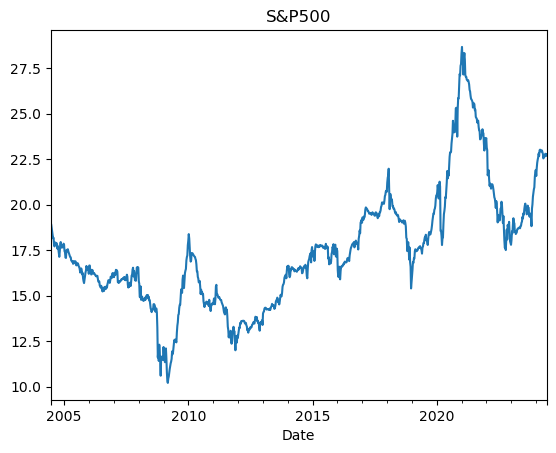

In [514]:
PE = FactSet.iloc[:,-1]
PE.plot(title = "S&P500")

log of Fed balance sheet:

<Axes: title={'center': 'Total Assets of the Federal Reserve System, log'}, xlabel='DATE'>

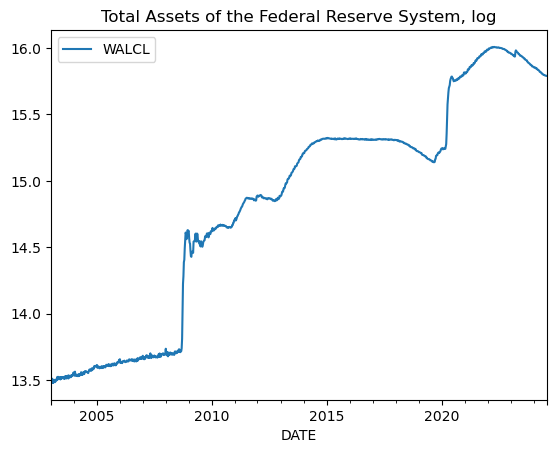

In [516]:
FED_BS = web.DataReader('WALCL', 'fred', start, end) 
FED_BS = FED_BS.resample('W').last()
ln_FED_BS = np.log(FED_BS)
ln_FED_BS.plot(title = "Total Assets of the Federal Reserve System, log")

10-year US treasuries

[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'U.S. 10-year treasury yield'}, xlabel='Date'>

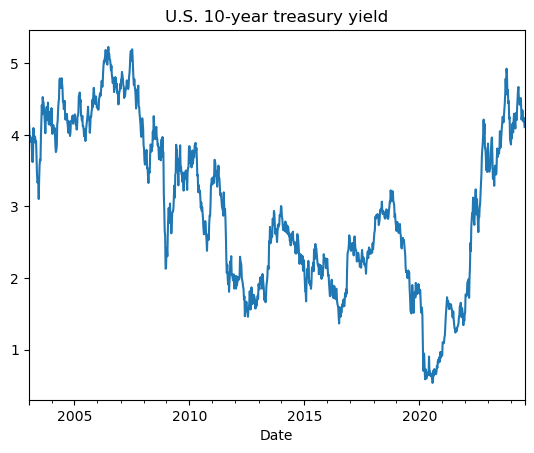

In [518]:
Tbonds = yf.download('^TNX', start=start, end=end)['Adj Close']  #10 year T-bonds from Yahoo Finance 
Tbonds = Tbonds.dropna().resample('W').last()
Tbonds.plot(title = "U.S. 10-year treasury yield")

In [519]:
df = pd.DataFrame()
df['Fed Balance, log'] = ln_FED_BS
df['10-year treasuries'] = Tbonds 
df['S&P500 P/E, log'] = np.log(PE) 
dfVAR = df.dropna()
dfVAR.describe()

,"Fed Balance, log",10-year treasuries,"S&P500 P/E, log"
count,1043.000000,1043.000000,1043.000000
mean,14.926637,2.902618,2.842993
std,0.778571,1.126469,0.184804
min,13.543484,0.536000,2.322250
25%,14.556174,2.005500,2.730006
50%,15.188170,2.755000,2.834474
75%,15.316637,3.854000,2.957823
max,16.008893,5.228000,3.356080


Stationary data:

In [521]:
df_rVAR = dfVAR - dfVAR.shift(1)
df_rVAR.dropna(inplace = True)
df_rVAR = df_rVAR
df_rVAR

,"Fed Balance, log",10-year treasuries,"S&P500 P/E, log"
DATE,,,
2004-06-27,0.017471,-0.065,-0.004476
2004-07-04,0.005553,-0.187,-0.010152
2004-07-11,-0.001817,0.008,-0.009139
2004-07-18,-0.003382,-0.105,-0.009953
2004-07-25,0.001582,0.071,-0.011937
...,...,...,...
2024-05-12,-0.001232,0.004,0.004241
2024-05-19,-0.006704,-0.084,0.003752
2024-05-26,-0.000644,0.047,-0.002010


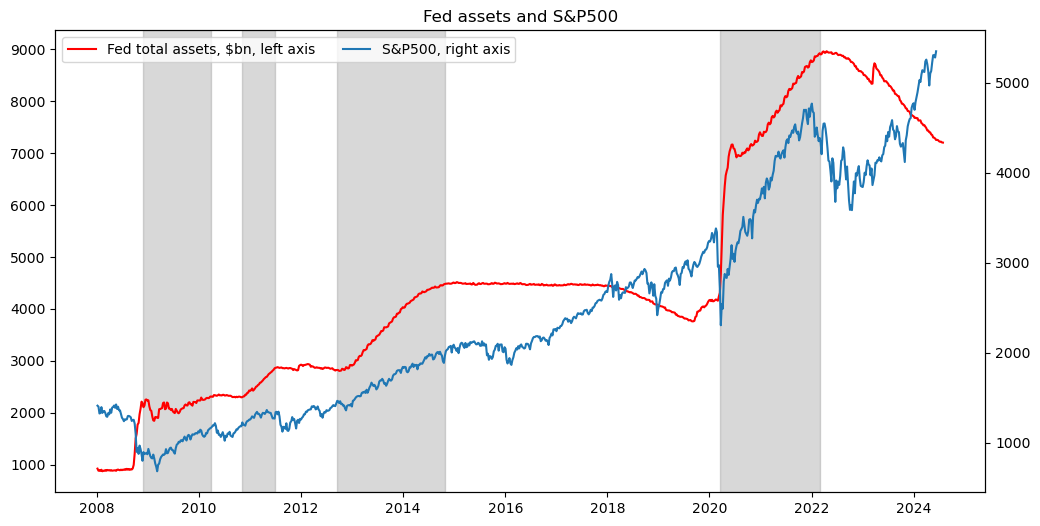

In [522]:
data1 = FED_BS.loc['2008-01-01':]
data2 = FactSet['Price'].loc['2008-01-01':]

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(data1.index, data1/1000, color = 'r', label = 'Fed total assets, $bn, left axis') 
ax2 = ax1.twinx() 
ax2.plot(data2.index, data2, label = 'S&P500, right axis')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', ncol=2)

shaded_periods = [
    ('2008-11-25', '2010-03-31'),  # QE1
    ('2010-11-03', '2011-06-30'),  # QE2
    ('2012-09-13', '2014-10-29'),   # QE3
    ('2020-03-15', '2022-02-28')
]

for start_date, end_date in shaded_periods:
    ax1.axvspan(start_date, end_date, color='grey', alpha=0.3)

plt.title('Fed assets and S&P500')

plt.show()

Timespans: 

In [524]:
dfVAR = dfVAR[['10-year treasuries','S&P500 P/E, log','Fed Balance, log']]
dfVAR

,10-year treasuries,"S&P500 P/E, log","Fed Balance, log"
DATE,,,
2004-06-20,4.710,2.944340,13.543484
2004-06-27,4.645,2.939864,13.560955
2004-07-04,4.458,2.929712,13.566508
2004-07-11,4.466,2.920573,13.564691
2004-07-18,4.361,2.910620,13.561310
...,...,...,...
2024-05-12,4.504,3.123167,15.810674
2024-05-19,4.420,3.126919,15.803970
2024-05-26,4.467,3.124909,15.803325


In [525]:
QE123 = dfVAR.loc['2008-01-01':'2015-01-01']
QE4 = dfVAR.loc['2020-01-01':]
QT = dfVAR.loc['2022-02-01':]

In [526]:
rQE123 = df_rVAR.loc['2008-01-01':'2015-01-01']
rQE4 = df_rVAR.loc['2020-01-01':]
rQT = df_rVAR.loc['2022-02-01':]

### Preliminary analysis

Check stationarity:

In [529]:
def check_stationarity(series, name):
    adf_test = adfuller(series)
    print(f'{name} ADF Test:')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}\n')

for i in dfVAR.columns:
    check_stationarity(dfVAR[i], i)

10-year treasuries ADF Test:
ADF Statistic: -1.8573902549145918
p-value: 0.35236373422661427

S&P500 P/E, log ADF Test:
ADF Statistic: -1.6551297930922904
p-value: 0.4543664777525627

Fed Balance, log ADF Test:
ADF Statistic: -1.4639456108114286
p-value: 0.5512656140728702



Data is non-stationary

In [531]:
def check_stationarity(series, name):
    adf_test = adfuller(series)
    print(f'{name} ADF Test:')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}\n')

for i in dfVAR.columns:
    check_stationarity(df_rVAR[i], i)

10-year treasuries ADF Test:
ADF Statistic: -14.529664861566127
p-value: 5.357097056221648e-27

S&P500 P/E, log ADF Test:
ADF Statistic: -7.225459865506177
p-value: 2.0586758910475201e-10

Fed Balance, log ADF Test:
ADF Statistic: -6.014164323806284
p-value: 1.5479184406912264e-07



Data in differences is stationary

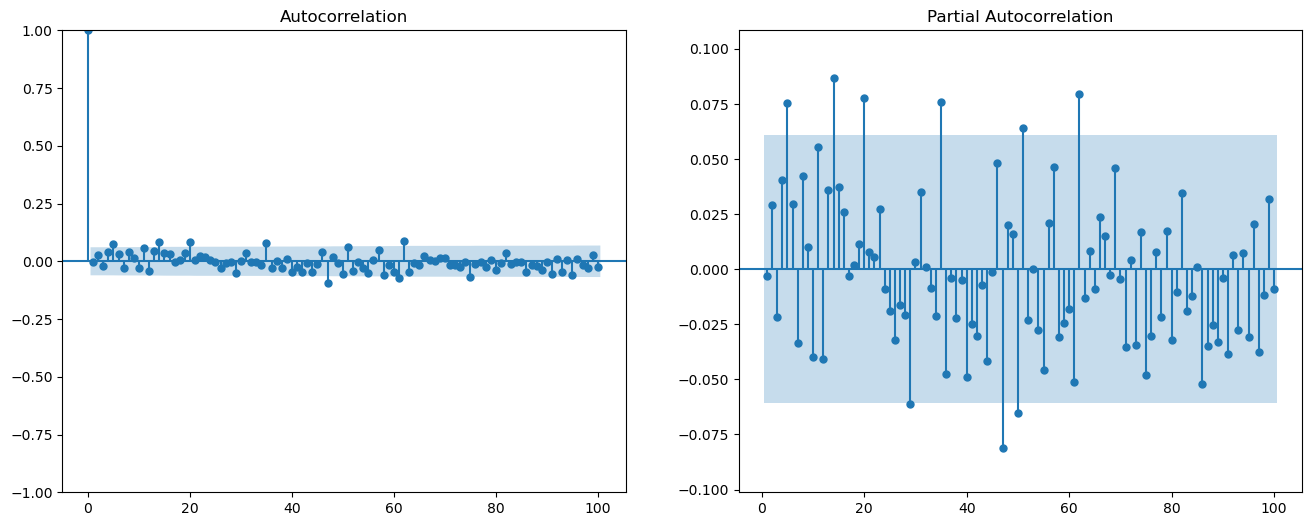

In [533]:
from statsmodels.graphics import tsaplots

i = df_rVAR.columns[2]
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
tsaplots.plot_acf(df_rVAR[i], lags=100, zero=True, ax=ax1, auto_ylims=False)   
ax2 = plt.subplot(122)
tsaplots.plot_pacf(df_rVAR[i], lags=100, zero=False, ax=ax2, auto_ylims=True)
plt.savefig(f'rPACF')

First check number of lags

In [535]:
VAR(dfVAR).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-4.581,-4.567,0.01024,-4.576
1,-20.79,-20.73,9.341e-10,-20.77
2,-21.02,-20.92,7.402e-10,-20.99
3,-21.08,-20.93,7.023e-10,-21.02
4,-21.09,-20.91,6.898e-10,-21.02
5,-21.19,-20.96*,6.262e-10,-21.10
6,-21.21,-20.93,6.147e-10,-21.11*
7,-21.21,-20.89,6.152e-10,-21.09
8,-21.20,-20.84,6.204e-10,-21.06
9,-21.21,-20.81,6.139e-10,-21.06


In [536]:
VAR(df_rVAR).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-20.78,-20.77,9.453e-10,-20.77
1,-21.02,-20.96,7.444e-10,-21.00
2,-21.07,-20.97,7.038e-10,-21.04
3,-21.09,-20.95,6.916e-10,-21.04
4,-21.19,-21.00*,6.270e-10,-21.12
5,-21.21,-20.98,6.153e-10,-21.12*
6,-21.21,-20.93,6.157e-10,-21.10
7,-21.20,-20.88,6.204e-10,-21.08
8,-21.21,-20.85,6.144e-10,-21.07
9,-21.20,-20.80,6.184e-10,-21.05


### Whole sample:

Start with 5 lags and increase the number till the autocorrelation soundly rejected 

In [539]:
res = VAR(dfVAR).fit(6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 01, Aug, 2024
Time:                     13:11:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -20.9605
Nobs:                     1037.00    HQIC:                  -21.1291
Log likelihood:           6651.58    FPE:                6.01137e-10
AIC:                     -21.2322    Det(Omega_mle):     5.69270e-10
--------------------------------------------------------------------
Results for equation 10-year treasuries
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.007643         0.102943           -0.074           0.941
L1.10-year treasuries         0.933328         0.032278           28.916           0.000
L1.S&P500 P/E, 

Residual check (done for all timespans):

In [541]:
for i in range(res.resid.shape[1]):
    print(dfVAR.columns[i], ':')
    print(acorr_ljungbox(res.resid.iloc[:, i]), "\n")

10-year treasuries :
     lb_stat  lb_pvalue
1   0.014668   0.903603
2   0.014745   0.992655
3   0.020175   0.999242
4   0.029219   0.999894
5   0.052005   0.999968
6   1.589090   0.953359
7   1.769582   0.971487
8   2.808027   0.945821
9   2.905205   0.967935
10  4.551764   0.919044 

S&P500 P/E, log :
     lb_stat  lb_pvalue
1   0.001279   0.971473
2   0.002972   0.998515
3   0.004306   0.999925
4   0.004994   0.999997
5   0.011138   0.999999
6   0.456671   0.998326
7   0.831214   0.997112
8   8.399067   0.395490
9   8.402936   0.494104
10  8.897737   0.541835 

Fed Balance, log :
     lb_stat  lb_pvalue
1   0.014877   0.902921
2   0.240238   0.886815
3   0.483171   0.922573
4   0.899429   0.924643
5   1.024544   0.960562
6   1.081914   0.982316
7   1.082995   0.993376
8   1.641472   0.990102
9   1.648970   0.995883
10  1.681730   0.998249 



Impulse response function: 

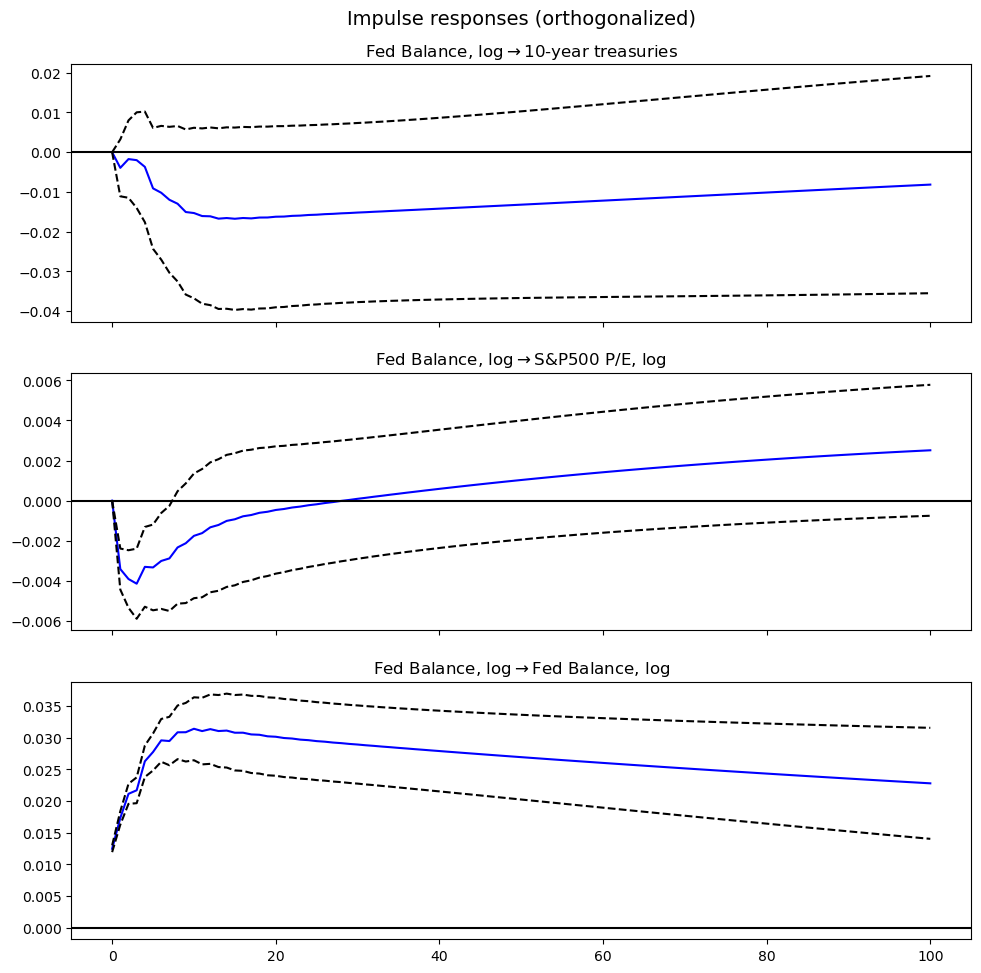

In [543]:
irf = res.irf(periods = 100)
irf.plot(orth=True, impulse='Fed Balance, log');

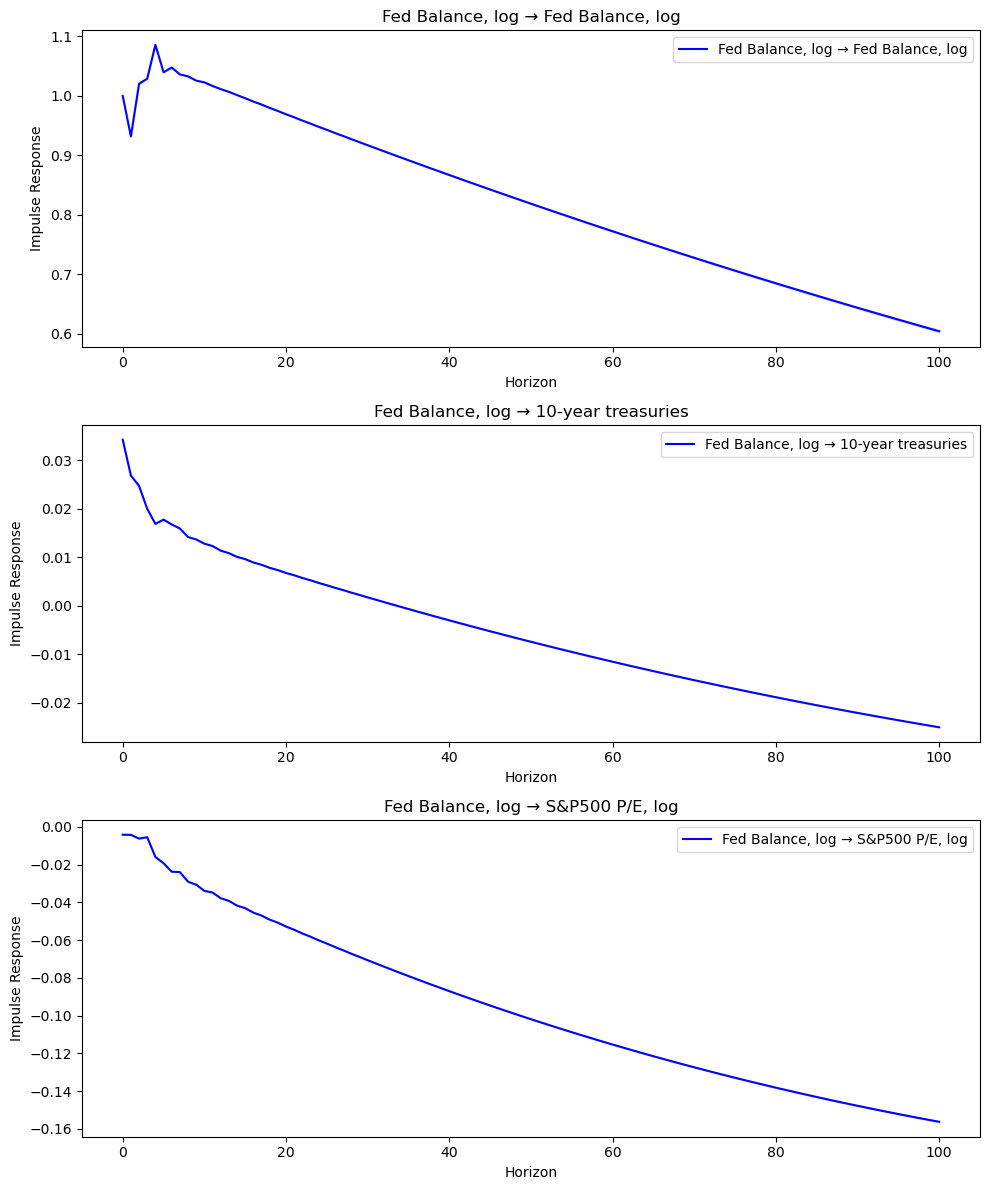

In [544]:
# Standard deviation of the shock (from your IRF plot or calculations)
std_dev_shock = irf.orth_irfs[0][3][3]  # 3.5% increase in assets corresponds to 1 std deviation

# Normalize the shock to 100% increase
normalized_shock = 1.0 / std_dev_shock  # This should give the factor to scale up the shock

# Apply the normalized shock to the IRF
irf_response = irf.orth_irfs * normalized_shock

# Plot the normalized IRF
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].plot(irf_response[:, 0, 0], label='Fed Balance, log → Fed Balance, log', color='blue')
axes[0].fill_between(range(len(irf_response[:, 0, 0])), 
                     irf_response[:, 0, 0] - 1.96 * irf.cov(orth=True)[:, 0, 0], 
                     irf_response[:, 0, 0] + 1.96 * irf.cov(orth=True)[:, 0, 0], 
                     color='blue', alpha=0.1)
axes[0].set_title('Fed Balance, log → Fed Balance, log')

axes[1].plot(irf_response[:, 1, 0], label='Fed Balance, log → 10-year treasuries', color='blue')
axes[1].fill_between(range(len(irf_response[:, 1, 0])), 
                     irf_response[:, 1, 0] - 1.96 * irf.cov(orth=True)[:, 1, 0], 
                     irf_response[:, 1, 0] + 1.96 * irf.cov(orth=True)[:, 1, 0], 
                     color='blue', alpha=0.1)
axes[1].set_title('Fed Balance, log → 10-year treasuries')

axes[2].plot(irf_response[:, 2, 0], label='Fed Balance, log → S&P500 P/E, log', color='blue')
axes[2].fill_between(range(len(irf_response[:, 2, 0])), 
                     irf_response[:, 2, 0] - 1.96 * irf.cov(orth=True)[:, 2, 0], 
                     irf_response[:, 2, 0] + 1.96 * irf.cov(orth=True)[:, 2, 0], 
                     color='blue', alpha=0.1)
axes[2].set_title('Fed Balance, log → S&P500 P/E, log')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Horizon')
    ax.set_ylabel('Impulse Response')

plt.tight_layout()
plt.show()

In [545]:
res = VAR(df_rVAR).fit(5)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 01, Aug, 2024
Time:                     13:12:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -21.0045
Nobs:                     1037.00    HQIC:                  -21.1465
Log likelihood:           6643.18    FPE:                6.00438e-10
AIC:                     -21.2334    Det(Omega_mle):     5.73482e-10
--------------------------------------------------------------------
Results for equation Fed Balance, log
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000868         0.000396            2.191           0.028
L1.Fed Balance, log           0.396165         0.030920           12.812           0.000
L1.10-year treasu

In [546]:
for i in range(res.resid.shape[1]):
    print(dfVAR.columns[i], ':')
    print(acorr_ljungbox(res.resid.iloc[:, i]), "\n")

10-year treasuries :
     lb_stat  lb_pvalue
1   0.010821   0.917151
2   0.226233   0.893047
3   0.482026   0.922822
4   0.881231   0.927238
5   0.985913   0.963694
6   1.031963   0.984372
7   1.031985   0.994296
8   1.596721   0.990983
9   1.605202   0.996288
10  1.628395   0.998477 

S&P500 P/E, log :
     lb_stat  lb_pvalue
1   0.018023   0.893206
2   0.018564   0.990761
3   0.027315   0.998809
4   0.039248   0.999810
5   0.065813   0.999942
6   1.736861   0.942240
7   1.969024   0.961535
8   2.877663   0.941799
9   2.934925   0.966819
10  4.757295   0.906790 

Fed Balance, log :
     lb_stat  lb_pvalue
1   0.000595   0.980540
2   0.000747   0.999627
3   0.000752   0.999995
4   0.006010   0.999995
5   0.016095   0.999998
6   0.420961   0.998672
7   0.819388   0.997241
8   8.273814   0.407191
9   8.275527   0.506636
10  8.806294   0.550580 



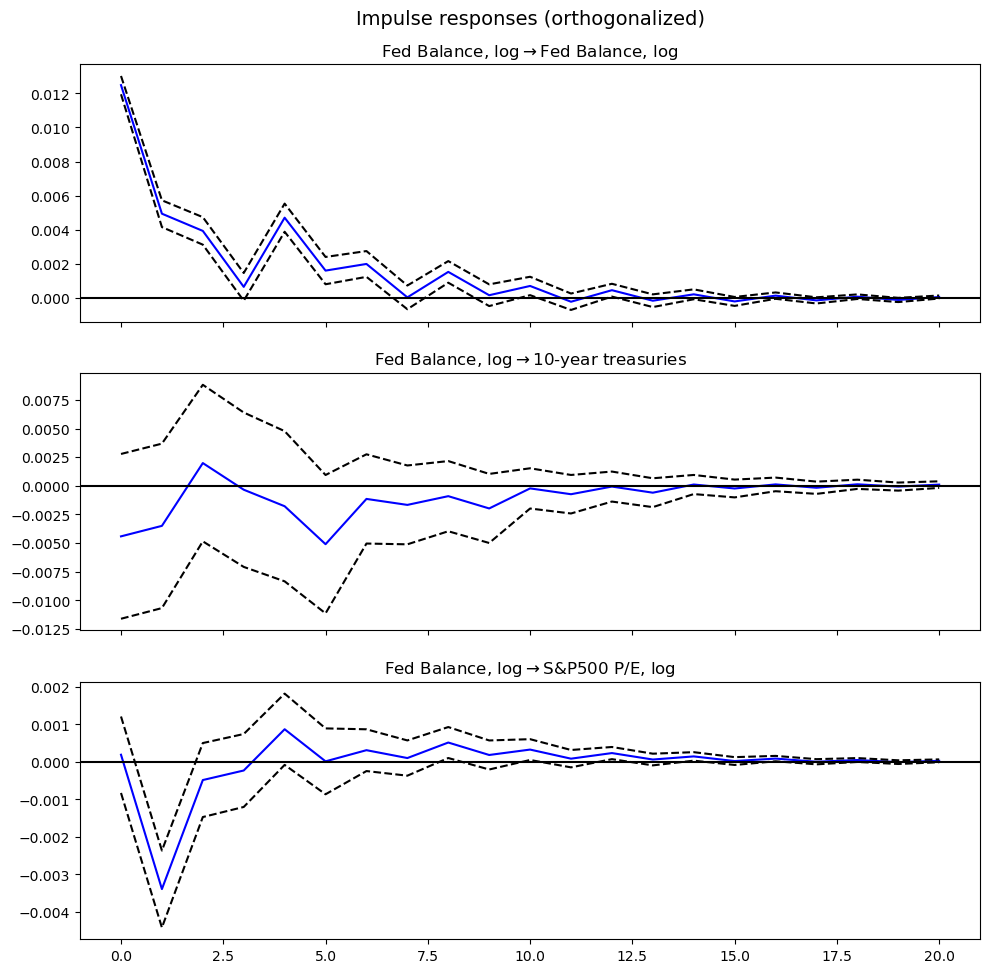

In [547]:
irf = res.irf(periods = 20)
irf.plot(orth=True, impulse='Fed Balance, log');

### QE1-3

In [549]:
VAR(QE123).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-7.841,-7.808,0.0003933,-7.828
1,-19.67,-19.54,2.867e-09,-19.62
2,-20.06,-19.82*,1.946e-09,-19.96*
3,-20.06,-19.73,1.933e-09,-19.93
4,-20.08,-19.65,1.893e-09,-19.91
5,-20.12,-19.59,1.826e-09,-19.91
6,-20.13,-19.50,1.810e-09,-19.88
7,-20.12,-19.39,1.829e-09,-19.83
8,-20.10,-19.27,1.865e-09,-19.77
9,-20.13,-19.20,1.816e-09,-19.76


In [550]:
res123 = VAR(QE123).fit(5)
res123.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 01, Aug, 2024
Time:                     13:12:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -19.6055
Nobs:                     360.000    HQIC:                  -19.9176
Log likelihood:           2137.80    FPE:                1.82181e-09
AIC:                     -20.1236    Det(Omega_mle):     1.59900e-09
--------------------------------------------------------------------
Results for equation 10-year treasuries
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.734227         0.344114            2.134           0.033
L1.10-year treasuries         0.892883         0.058858           15.170           0.000
L1.S&P500 P/E, 

In [551]:
for i in range(res123.resid.shape[1]):
    print(dfVAR.columns[i], ':')
    print(acorr_ljungbox(res123.resid.iloc[:, i]), "\n")

10-year treasuries :
     lb_stat  lb_pvalue
1   0.000026   0.995920
2   0.003277   0.998363
3   0.051280   0.996959
4   0.073259   0.999345
5   1.486137   0.914664
6   1.838118   0.933968
7   2.365246   0.936898
8   4.482741   0.811157
9   4.622822   0.865871
10  7.866072   0.641917 

S&P500 P/E, log :
      lb_stat  lb_pvalue
1    0.000721   0.978585
2    0.009326   0.995348
3    0.072393   0.994931
4    0.817911   0.936031
5    2.324599   0.802647
6    3.889878   0.691576
7    3.935652   0.787159
8   11.035528   0.199694
9   11.036761   0.273198
10  11.427317   0.325209 

Fed Balance, log :
      lb_stat  lb_pvalue
1    1.187135   0.275908
2    1.291649   0.524230
3    2.074423   0.557104
4    5.439014   0.245142
5    9.842573   0.079821
6   11.272340   0.080315
7   11.761446   0.108682
8   13.856009   0.085597
9   13.888384   0.126351
10  14.416641   0.154821 



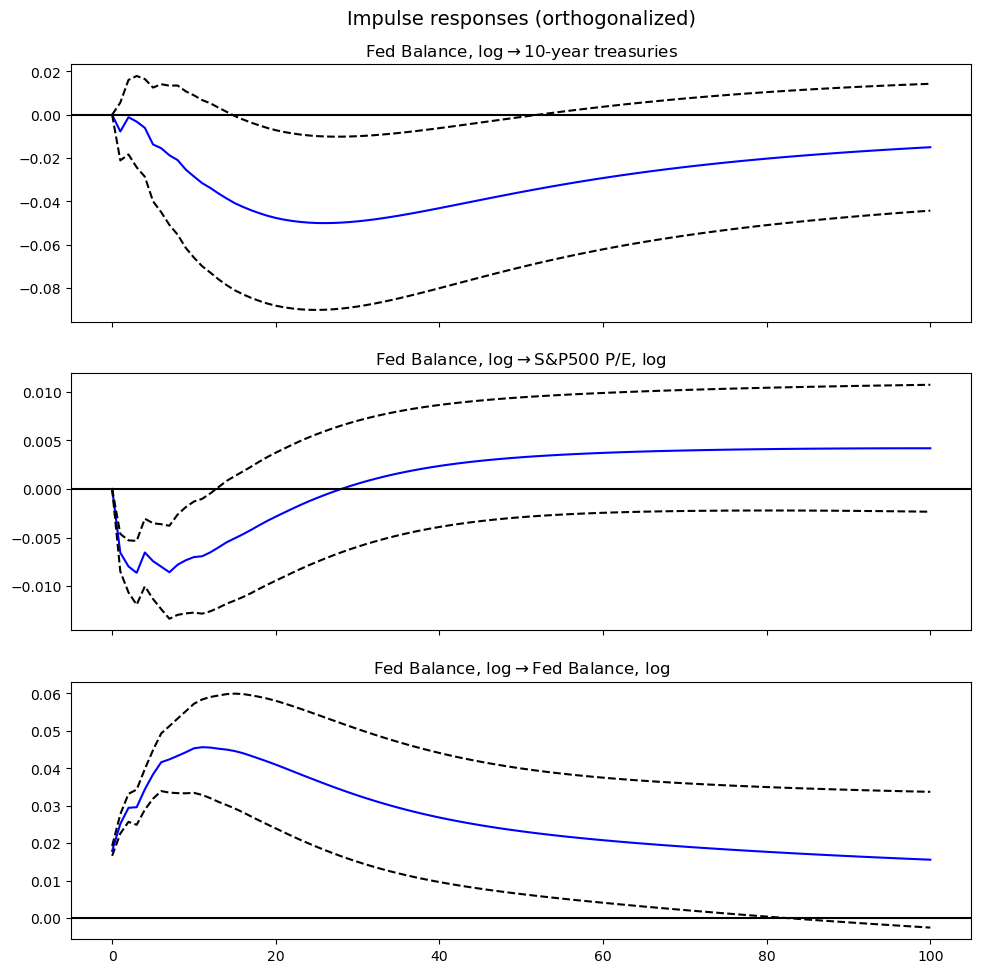

In [552]:
irf123 = res123.irf(periods = 100)
irf123.plot(orth=True, impulse='Fed Balance, log');

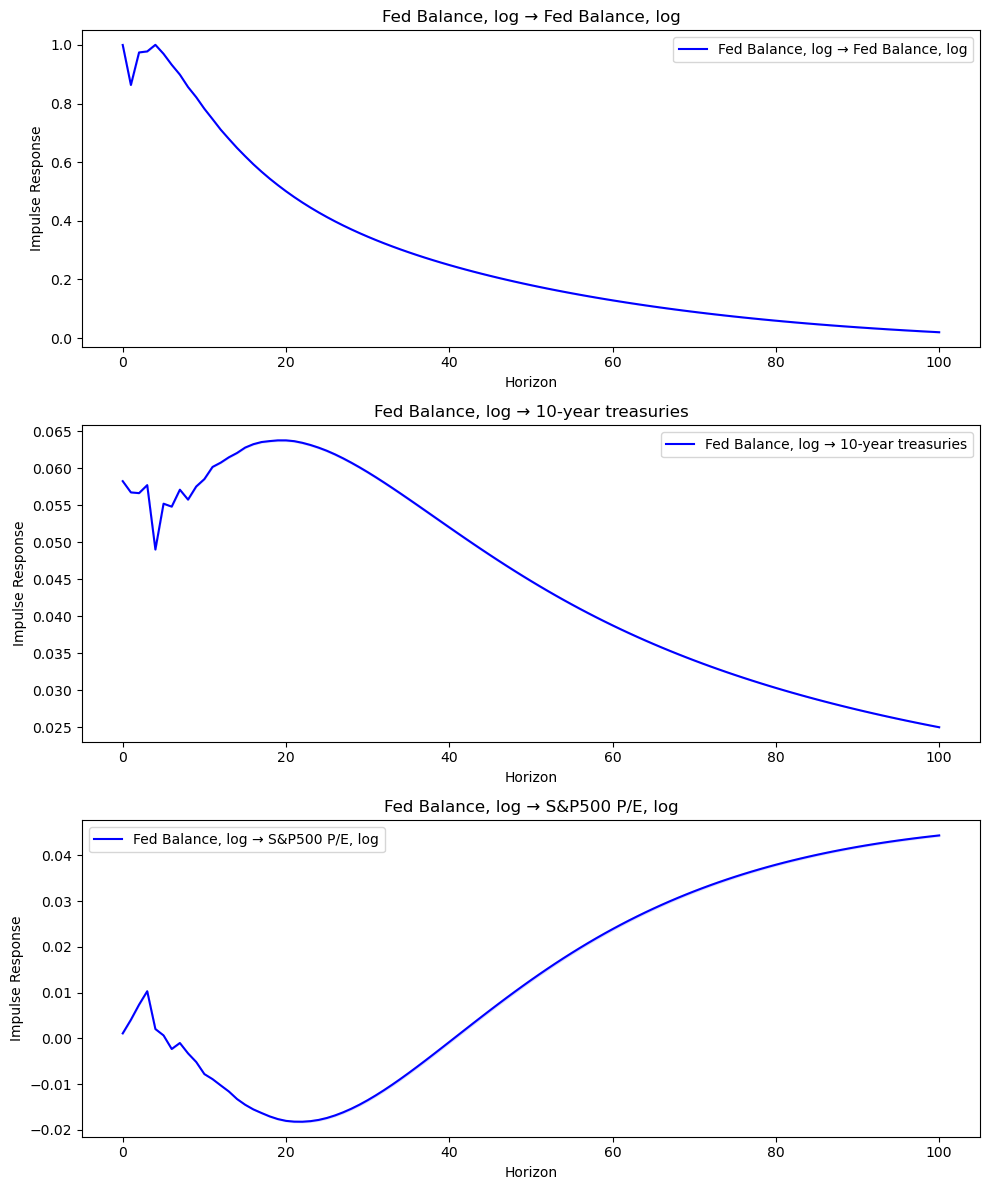

In [554]:
# Standard deviation of the shock (from your IRF plot or calculations)
std_dev_shock = irf123.orth_irfs[0][0][0]  # 3.5% increase in assets corresponds to 1 std deviation

# Normalize the shock to 100% increase
normalized_shock = 1.0 / std_dev_shock  # This should give the factor to scale up the shock

# Apply the normalized shock to the IRF
irf_response = irf123.orth_irfs * normalized_shock

# Plot the normalized IRF
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].plot(irf_response[:, 0, 0], label='Fed Balance, log → Fed Balance, log', color='blue')
axes[0].fill_between(range(len(irf_response[:, 0, 0])), 
                     irf_response[:, 0, 0] - 1.96 * irf123.cov(orth=True)[:, 0, 0], 
                     irf_response[:, 0, 0] + 1.96 * irf123.cov(orth=True)[:, 0, 0], 
                     color='blue', alpha=0.1)
axes[0].set_title('Fed Balance, log → Fed Balance, log')

axes[1].plot(irf_response[:, 1, 0], label='Fed Balance, log → 10-year treasuries', color='blue')
axes[1].fill_between(range(len(irf_response[:, 1, 0])), 
                     irf_response[:, 1, 0] - 1.96 * irf123.cov(orth=True)[:, 1, 0], 
                     irf_response[:, 1, 0] + 1.96 * irf123.cov(orth=True)[:, 1, 0], 
                     color='blue', alpha=0.1)
axes[1].set_title('Fed Balance, log → 10-year treasuries')

axes[2].plot(irf_response[:, 2, 0], label='Fed Balance, log → S&P500 P/E, log', color='blue')
axes[2].fill_between(range(len(irf_response[:, 2, 0])), 
                     irf_response[:, 2, 0] - 1.96 * irf123.cov(orth=True)[:, 2, 0], 
                     irf_response[:, 2, 0] + 1.96 * irf123.cov(orth=True)[:, 2, 0], 
                     color='blue', alpha=0.1)
axes[2].set_title('Fed Balance, log → S&P500 P/E, log')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Horizon')
    ax.set_ylabel('Impulse Response')

plt.tight_layout()
plt.show()

In [555]:
VAR(rQE123).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-19.64,-19.60,2.964e-09,-19.62
1,-20.03,-19.90*,1.993e-09,-19.98*
2,-20.04,-19.81,1.982e-09,-19.95
3,-20.07,-19.73,1.930e-09,-19.93
4,-20.10,-19.67,1.871e-09,-19.93
5,-20.12,-19.59,1.831e-09,-19.91
6,-20.11,-19.48,1.849e-09,-19.86
7,-20.09,-19.36,1.880e-09,-19.80
8,-20.12,-19.29,1.834e-09,-19.79
9,-20.12,-19.19,1.832e-09,-19.75


In [556]:
res123 = VAR(rQE123).fit(5)

In [557]:
for i in range(res123.resid.shape[1]):
    print(dfVAR.columns[i], ':')
    print(acorr_ljungbox(res123.resid.iloc[:, i]), "\n")

10-year treasuries :
     lb_stat  lb_pvalue
1   0.042895   0.835923
2   0.048708   0.975940
3   0.191286   0.978984
4   0.878590   0.927612
5   0.885005   0.971298
6   0.918888   0.988501
7   0.974453   0.995230
8   3.593774   0.891791
9   3.900389   0.917845
10  4.753441   0.907028 

S&P500 P/E, log :
     lb_stat  lb_pvalue
1   0.140582   0.707703
2   0.161742   0.922313
3   0.245828   0.969873
4   0.255755   0.992488
5   0.352679   0.996533
6   2.164532   0.903962
7   2.612012   0.918429
8   3.708376   0.882430
9   3.748229   0.927188
10  7.917208   0.636924 

Fed Balance, log :
     lb_stat  lb_pvalue
1   0.007396   0.931466
2   0.074920   0.963233
3   0.085038   0.993570
4   0.095097   0.998905
5   0.179392   0.999320
6   1.605371   0.952191
7   1.616111   0.978016
8   9.271564   0.319908
9   9.275208   0.412268
10  9.599421   0.476311 



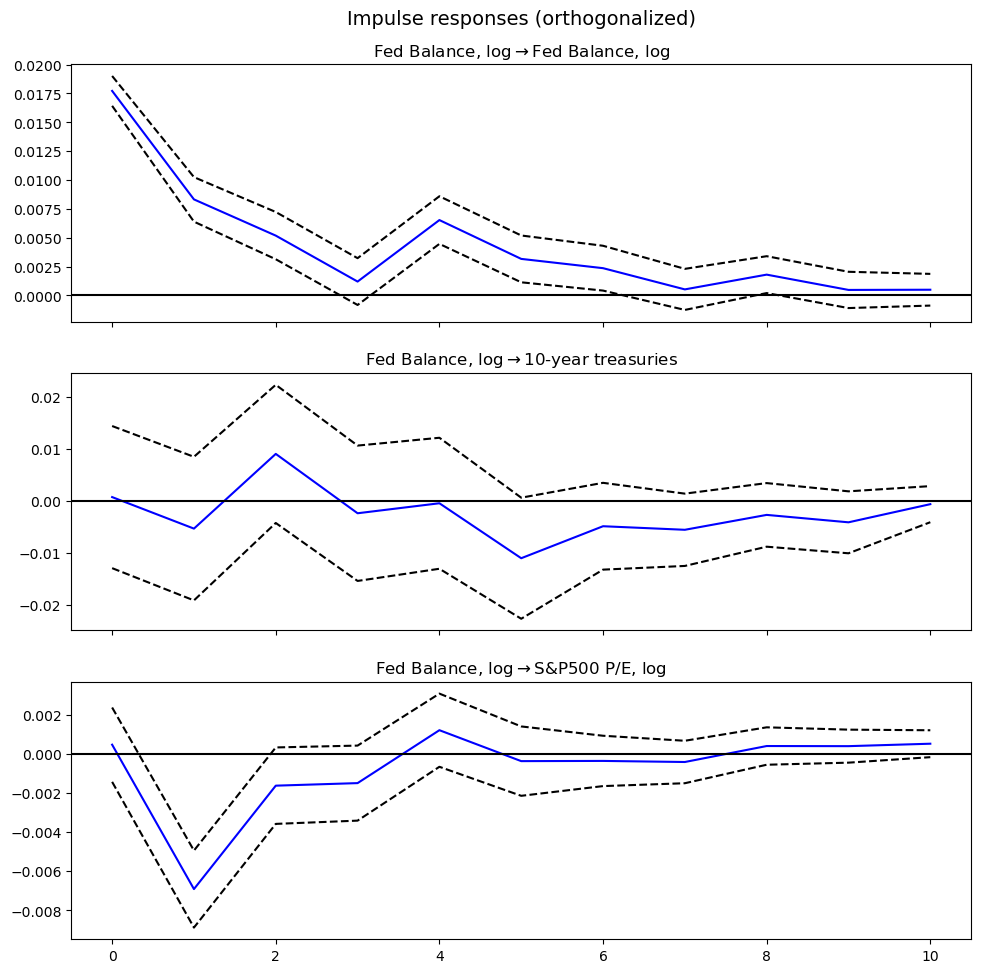

In [558]:
res123.irf().plot(orth=True, impulse='Fed Balance, log');

### QE4

In [560]:
VAR(QE4).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-9.199,-9.153,0.0001011,-9.181
1,-22.56,-22.37,1.600e-10,-22.48
2,-22.71,-22.38*,1.370e-10,-22.58*
3,-22.68,-22.21,1.413e-10,-22.49
4,-22.73,-22.12,1.345e-10,-22.48
5,-22.74*,-21.99,1.336e-10*,-22.44
6,-22.71,-21.82,1.376e-10,-22.35
7,-22.68,-21.65,1.417e-10,-22.26
8,-22.65,-21.48,1.467e-10,-22.17
9,-22.62,-21.31,1.508e-10,-22.09


In [561]:
res4 = VAR(QE4).fit(4)

In [562]:
for i in range(res4.resid.shape[1]):
    print(dfVAR.columns[i], ':')
    print(acorr_ljungbox(res4.resid.iloc[:, i]), "\n")

10-year treasuries :
     lb_stat  lb_pvalue
1   0.010587   0.918047
2   0.018424   0.990830
3   0.025615   0.998918
4   0.878925   0.927565
5   2.636984   0.755738
6   2.646556   0.851719
7   2.708177   0.910623
8   3.014154   0.933466
9   3.310983   0.950680
10  3.476833   0.967879 

S&P500 P/E, log :
     lb_stat  lb_pvalue
1   0.005108   0.943025
2   0.044533   0.977980
3   0.046244   0.997392
4   0.047485   0.999723
5   0.851214   0.973652
6   1.965262   0.922866
7   2.456233   0.930357
8   2.513176   0.961114
9   2.519538   0.980353
10  2.522125   0.990549 

Fed Balance, log :
      lb_stat  lb_pvalue
1    1.684420   0.194338
2    2.393623   0.302156
3    2.914802   0.404948
4    4.663730   0.323572
5   12.936076   0.023985
6   14.814802   0.021747
7   14.878833   0.037584
8   15.043680   0.058302
9   15.397323   0.080585
10  15.472604   0.115758 



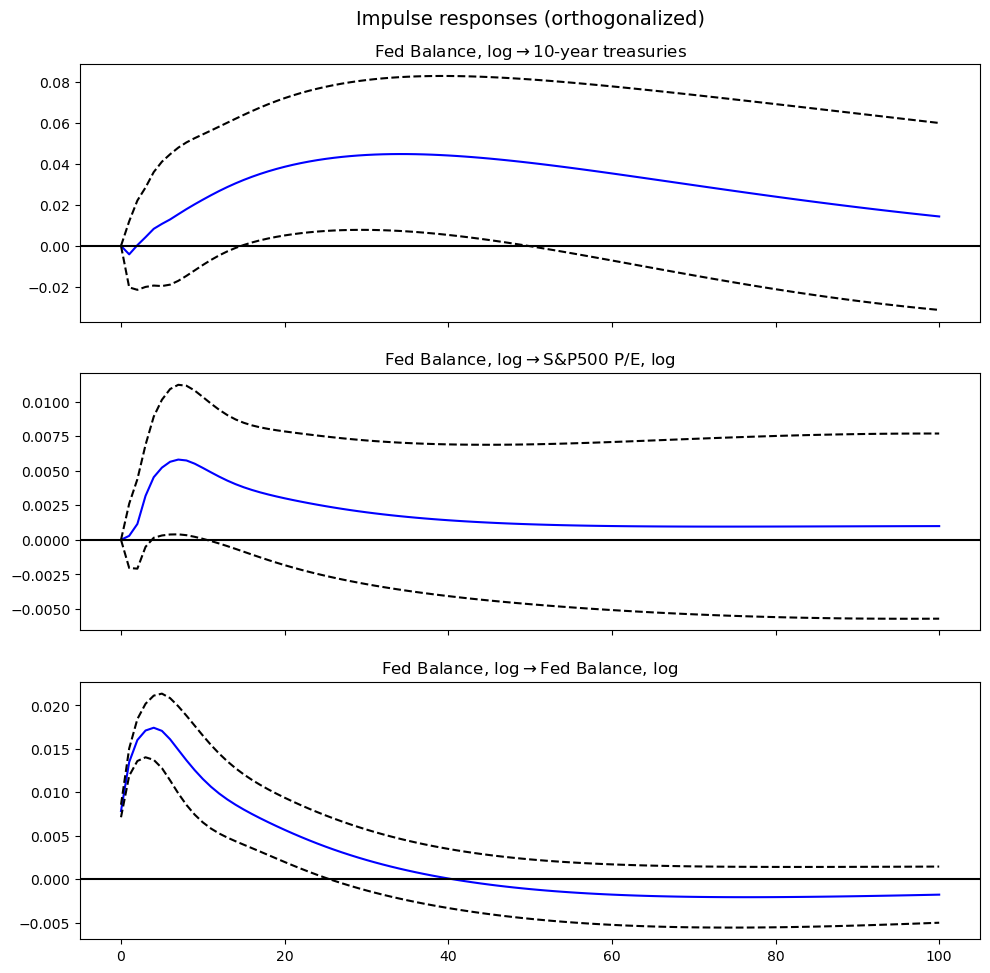

In [563]:
irf4 = res4.irf(periods = 100)
irf4.plot(orth=True, impulse='Fed Balance, log');

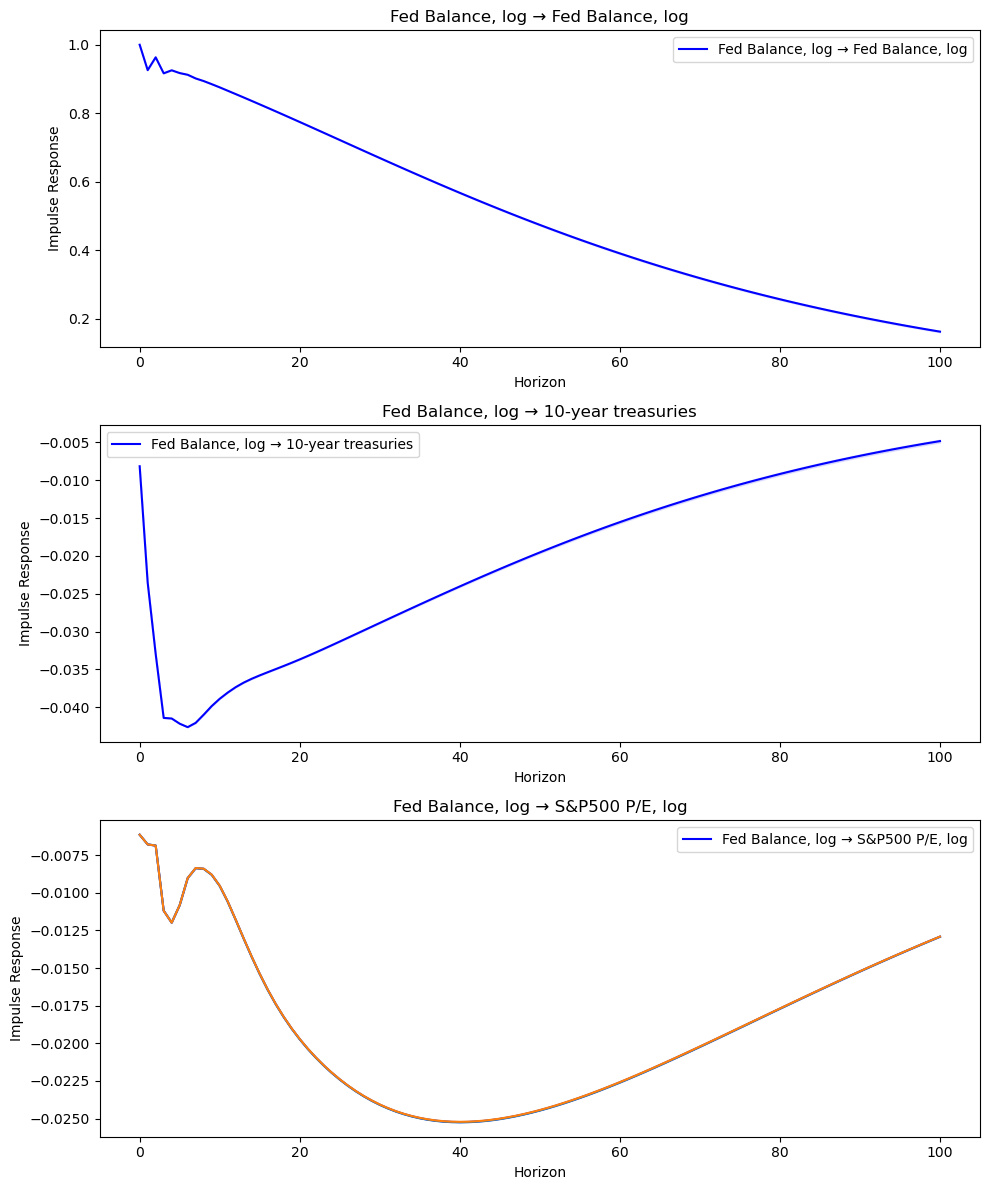

In [565]:
# Standard deviation of the shock (from your IRF plot or calculations)
std_dev_shock = irf4.orth_irfs[0][0][0]  # 3.5% increase in assets corresponds to 1 std deviation

# Normalize the shock to 100% increase
normalized_shock = 1.0 / std_dev_shock  # This should give the factor to scale up the shock

# Apply the normalized shock to the IRF
irf_response = irf4.orth_irfs * normalized_shock

# Plot the normalized IRF
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].plot(irf_response[:, 0, 0], label='Fed Balance, log → Fed Balance, log', color='blue')


axes[0].fill_between(range(len(irf_response[:, 0, 0])), 
                     irf_response[:, 0, 0] - 1.96 * irf4.cov(orth=True)[:, 0, 0], 
                     irf_response[:, 0, 0] + 1.96 * irf4.cov(orth=True)[:, 0, 0], 
                     color='blue', alpha=0.1)
axes[0].set_title('Fed Balance, log → Fed Balance, log')

axes[1].plot(irf_response[:, 1, 0], label='Fed Balance, log → 10-year treasuries', color='blue')
axes[1].fill_between(range(len(irf_response[:, 1, 0])), 
                     irf_response[:, 1, 0] - 1.96 * irf4.cov(orth=True)[:, 1, 0], 
                     irf_response[:, 1, 0] + 1.96 * irf4.cov(orth=True)[:, 1, 0], 
                     color='blue', alpha=0.1)
axes[1].set_title('Fed Balance, log → 10-year treasuries')

axes[2].plot(irf_response[:, 2, 0], label='Fed Balance, log → S&P500 P/E, log', color='blue')
axes[2].plot(irf_response[:, 2, 0] - 1.96 * irf4.cov(orth=True)[:, 2, 0])
axes[2].plot(irf_response[:, 2, 0] + 1.96 * irf4.cov(orth=True)[:, 2, 0])

axes[2].fill_between(range(len(irf_response[:, 2, 0])), 
                     irf_response[:, 2, 0] - 1.96 * irf4.cov(orth=True)[:, 2, 0], 
                     irf_response[:, 2, 0] + 1.96 * irf4.cov(orth=True)[:, 2, 0], 
                     color='blue', alpha=0.1)
axes[2].set_title('Fed Balance, log → S&P500 P/E, log')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Horizon')
    ax.set_ylabel('Impulse Response')

plt.tight_layout()
plt.show()

In [566]:
VAR(rQE4).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-22.23,-22.19,2.211e-10,-22.21
1,-22.55,-22.37*,1.606e-10,-22.48*
2,-22.57,-22.24,1.576e-10,-22.44
3,-22.63*,-22.16,1.485e-10*,-22.44
4,-22.62,-22.01,1.503e-10,-22.37
5,-22.59,-21.84,1.549e-10,-22.29
6,-22.58,-21.69,1.565e-10,-22.22
7,-22.55,-21.52,1.609e-10,-22.14
8,-22.51,-21.34,1.681e-10,-22.04
9,-22.49,-21.18,1.718e-10,-21.96


In [613]:
res4 = VAR(rQE4).fit(5)

In [615]:
for i in range(res4.resid.shape[1]):
    print(dfVAR.columns[i], ':')
    print(acorr_ljungbox(res4.resid.iloc[:, i]), "\n")

10-year treasuries :
      lb_stat  lb_pvalue
1    0.362003   0.547396
2    0.409315   0.814926
3    0.558027   0.905970
4    0.572997   0.966017
5    5.397716   0.369292
6    5.682405   0.459690
7    8.504297   0.290230
8    9.727986   0.284639
9   10.782229   0.290932
10  13.338627   0.205350 

S&P500 P/E, log :
     lb_stat  lb_pvalue
1   0.002814   0.957695
2   0.004865   0.997570
3   0.016034   0.999463
4   0.093240   0.998946
5   0.455470   0.993663
6   0.462503   0.998265
7   0.487081   0.999492
8   0.628571   0.999683
9   0.897682   0.999639
10  0.904907   0.999891 

Fed Balance, log :
     lb_stat  lb_pvalue
1   0.060018   0.806467
2   0.068194   0.966478
3   0.079744   0.994152
4   1.033097   0.904737
5   1.119077   0.952401
6   1.786010   0.938290
7   1.856274   0.967365
8   1.981310   0.981579
9   2.468673   0.981714
10  2.530604   0.990422 



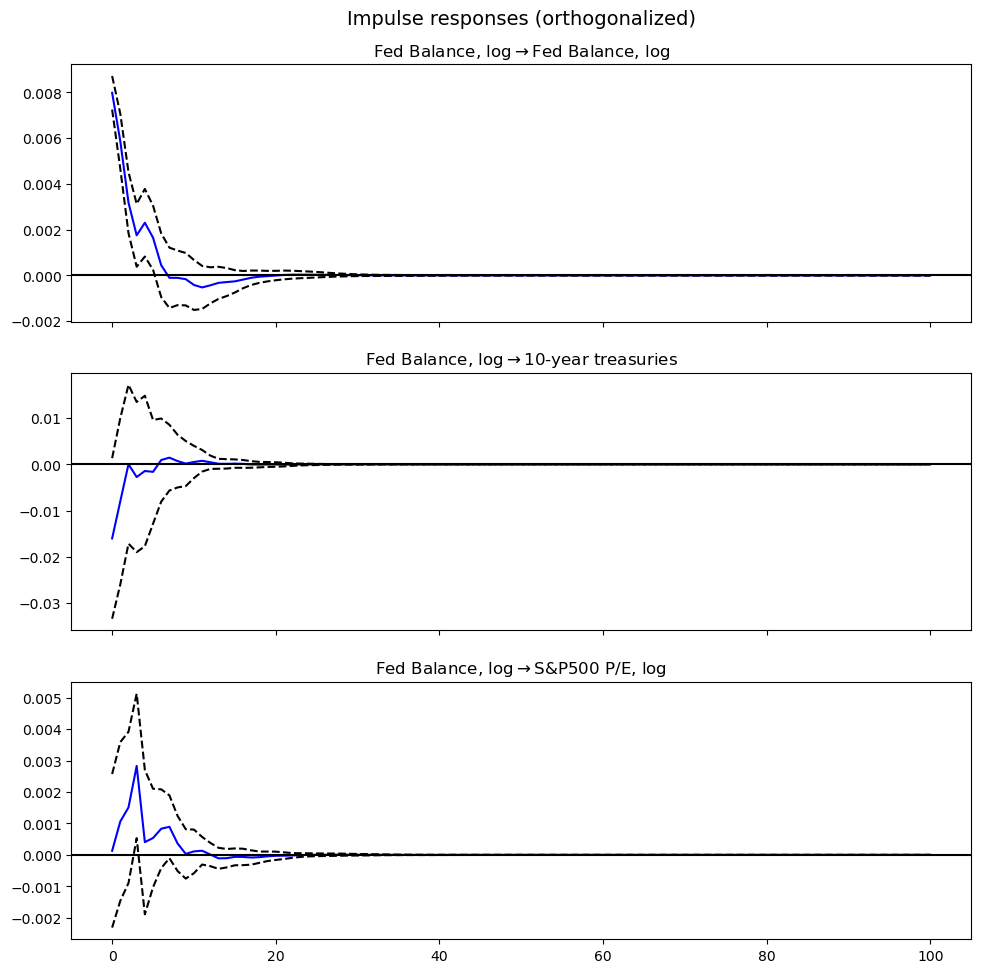

In [619]:
irf4 = res4.irf(periods=100)
irf4.plot(orth=True, impulse='Fed Balance, log').savefig('rQE4');

## EU

In [582]:
FactSetEU = pd.read_excel("C:\\Users\\Asus\\Downloads\\PriceHistory EU.xlsx", header = 2)[1:].set_index('Date').resample('W').mean()
FactSetEU 

,Price,CVol,Change,% Change,"Total Return (Gross, Unhedged)","Cumulative Return % (Gross, Unhedged)",Open,High,Low,P/E - LTM
Date,,,,,,,,,,
2004-06-20,2822.055312,5.419076e+08,NaN,NaN,648.590000,NaN,2796.07,2822.06,2759.27,15.723679
2004-06-27,2818.855081,4.210421e+08,-3.200231,-0.113401,649.320000,0.112552,2826.40,2822.35,2782.43,15.616814
2004-07-04,2783.993110,3.685387e+08,-34.861971,-1.236742,641.710000,-1.060763,2818.18,2840.04,2783.99,15.505503
2004-07-11,2776.249456,3.021699e+08,-7.743654,-0.278149,639.930000,-1.335204,2784.09,2784.92,2764.31,15.386858
2004-07-18,2713.267085,7.097844e+08,-62.982371,-2.268614,625.560000,-3.550779,2774.95,2763.20,2713.27,15.178629
...,...,...,...,...,...,...,...,...,...,...
2024-05-19,5064.140571,3.414462e+08,-20.943196,-0.411855,2402.970245,270.491411,5083.54,5102.30,5040.23,14.733687
2024-05-26,5035.405453,1.941698e+08,-28.735119,-0.567423,2395.789258,269.384242,5060.62,5079.04,4991.70,14.684734
2024-06-02,4983.673361,5.933419e+08,-51.732091,-1.027367,2374.343031,266.077650,5038.92,5071.39,4947.21,14.617977


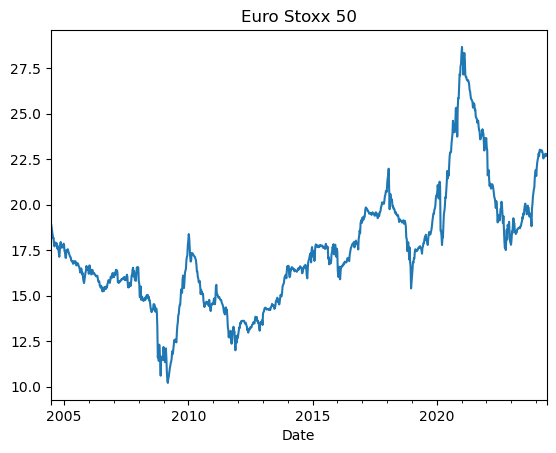

In [583]:
PE_EU = FactSet.iloc[:,-1]
PE_EU.plot(title = "Euro Stoxx 50");

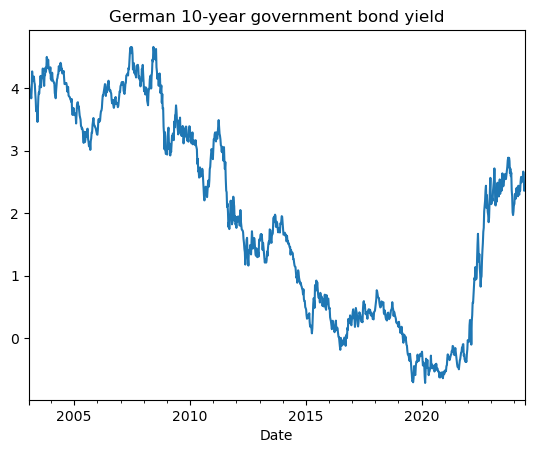

In [584]:
GBonds = pd.read_csv("C:\\Users\\Asus\\Downloads\\Germany 10-Year Bond Yield Historical Data.csv").set_index('Date')['Price']
GBonds.index = pd.to_datetime(GBonds.index)
GBonds.plot(title = 'German 10-year government bond yield');

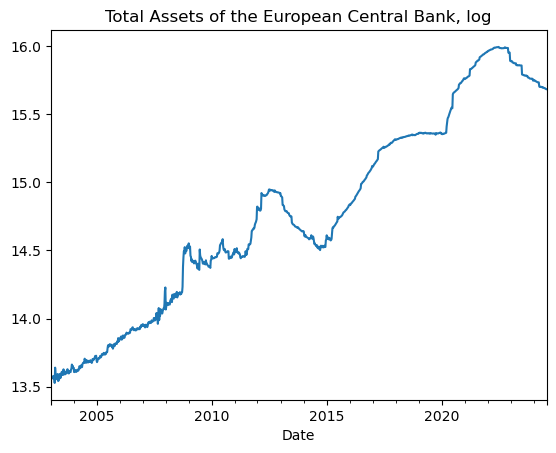

In [585]:
ECB_BS = web.DataReader('ECBASSETSW', 'fred', start, end).resample('W').last() 
ln_ECB_BS = np.log(ECB_BS).rename_axis("Date")
ln_ECB_BS.plot(title = "Total Assets of the European Central Bank, log", legend = None);

In [586]:
df_EU = pd.DataFrame()
df_EU['ECB Balance, log'] = ln_ECB_BS 
df_EU['10-year bonds'] = GBonds
df_EU['EuroStoxx 50 P/E'] = np.log(PE_EU) 
df_EU_VAR = df_EU.dropna()
df_EU_VAR

,"ECB Balance, log",10-year bonds,EuroStoxx 50 P/E
Date,,,
2004-06-20,13.673711,4.299,2.944340
2004-06-27,13.705515,4.308,2.939864
2004-07-04,13.690354,4.231,2.929712
2004-07-11,13.688842,4.254,2.920573
2004-07-18,13.674914,4.251,2.910620
...,...,...,...
2024-05-12,15.699690,2.519,3.123167
2024-05-19,15.696871,2.580,3.126919
2024-05-26,15.699195,2.663,3.124909


In [587]:
rdf_EU_VAR = (df_EU_VAR - df_EU_VAR.shift(1)).dropna()
rdf_EU_VAR

,"ECB Balance, log",10-year bonds,EuroStoxx 50 P/E
Date,,,
2004-06-27,0.031804,0.0090,-0.004476
2004-07-04,-0.015161,-0.0770,-0.010152
2004-07-11,-0.001512,0.0230,-0.009139
2004-07-18,-0.013928,-0.0030,-0.009953
2004-07-25,0.021397,0.0190,-0.011937
...,...,...,...
2024-05-12,-0.000170,0.0075,0.004241
2024-05-19,-0.002819,0.0610,0.003752
2024-05-26,0.002324,0.0830,-0.002010


Samples:

In [589]:
CMP = df_EU_VAR.loc['2011-01-01':'2015-01-01']
APP = df_EU_VAR.loc['2014-10-01':'2019-01-01']
PEPP = df_EU_VAR.loc['2020-01-01':]
QT = df_EU_VAR.loc['2022-01-01':]

In [590]:
rCMP = rdf_EU_VAR.loc['2011-01-01':'2015-01-01']
rAPP = rdf_EU_VAR.loc['2014-10-01':'2019-01-01']
rPEPP = rdf_EU_VAR.loc['2020-01-01':'2022-01-01']
rQT = rdf_EU_VAR.loc['2022-01-01':]

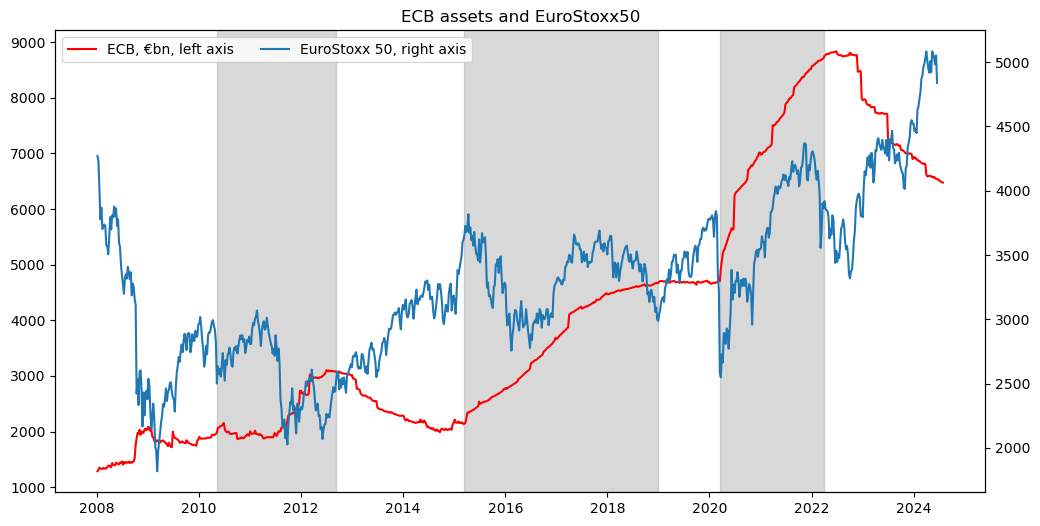

In [591]:
data1 = ECB_BS.loc['2008-01-01':]
data2 = FactSetEU['Price'].loc['2008-01-01':]

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(data1.index, data1/1000, color = 'r', label = 'ECB, €bn, left axis') 
ax2 = ax1.twinx() 
ax2.plot(data2.index, data2, label = 'EuroStoxx 50, right axis')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', ncol=2)

shaded_periods = [
    ('2010-05-10', '2012-09-06'),
    ('2015-03-09', '2018-12-31'),  
    ('2020-03-15', '2022-03-31')   
]

for start_date, end_date in shaded_periods:
    ax1.axvspan(start_date, end_date, color='grey', alpha=0.3)

plt.title('ECB assets and EuroStoxx50')
plt.savefig('ESECB')
plt.show()

### Whole sample (example)

In [593]:
#VAR(df_EU_VAR).select_order().summary()
#VAR(CMP).select_order().summary()
#VAR(APP).select_order().summary()
VAR(PEPP).select_order().summary()
# VAR(QT).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-8.549,-8.502,0.0001938,-8.530
1,-21.66*,-21.48*,3.910e-10*,-21.59*
2,-21.63,-21.31,4.027e-10,-21.50
3,-21.60,-21.14,4.142e-10,-21.42
4,-21.56,-20.95,4.336e-10,-21.31
5,-21.53,-20.78,4.463e-10,-21.23
6,-21.50,-20.61,4.621e-10,-21.14
7,-21.45,-20.42,4.866e-10,-21.03
8,-21.42,-20.25,4.986e-10,-20.95
9,-21.36,-20.05,5.305e-10,-20.83


In [594]:
#resEU = VAR(df_EU_VAR).fit(5)
#resEU = VAR(CMP).fit(5)
#resEU = VAR(APP).fit(5)
resEU = VAR(PEPP).fit(5)
#resEU = VAR(QT).fit(5)

In [595]:
for i in range(resEU.resid.shape[1]):
    print(df_EU_VAR.columns[i], ':')
    print(acorr_ljungbox(resEU.resid.iloc[:, i]), "\n")

ECB Balance, log :
     lb_stat  lb_pvalue
1   0.131715   0.716661
2   0.252415   0.881432
3   0.316534   0.956889
4   0.575092   0.965791
5   0.916290   0.969031
6   1.760742   0.940336
7   2.177499   0.949366
8   3.218591   0.919900
9   3.281840   0.952065
10  3.977596   0.948352 

10-year bonds :
     lb_stat  lb_pvalue
1   0.010802   0.917222
2   0.011142   0.994444
3   0.022027   0.999136
4   0.323207   0.988267
5   1.120461   0.952277
6   1.755452   0.940761
7   4.685141   0.698324
8   5.048872   0.752340
9   8.328673   0.501393
10  8.418494   0.588030 

EuroStoxx 50 P/E :
     lb_stat  lb_pvalue
1   0.014397   0.904493
2   0.020342   0.989881
3   0.109861   0.990628
4   1.500570   0.826541
5   1.614232   0.899523
6   1.614232   0.951549
7   1.837749   0.968272
8   1.998297   0.981064
9   2.310540   0.985552
10  2.453543   0.991536 



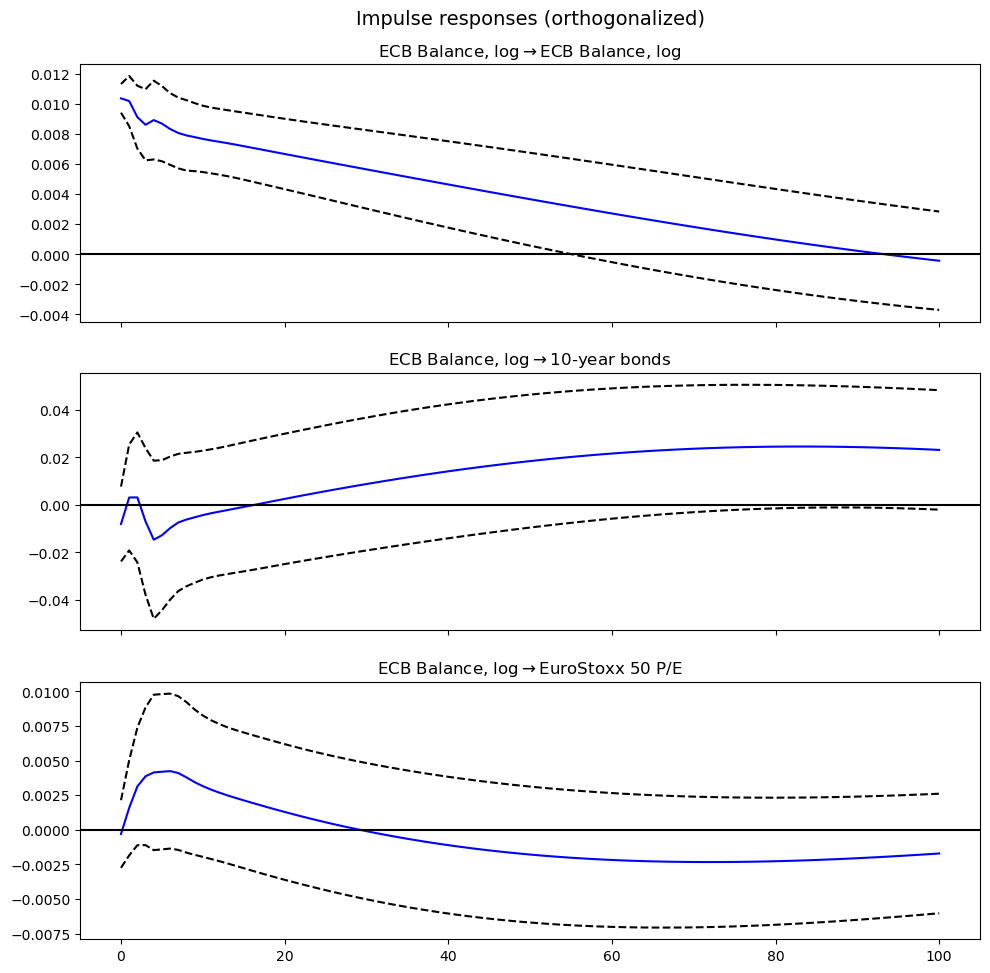

In [596]:
resEU.irf(periods = 100).plot(orth=True, impulse='ECB Balance, log');

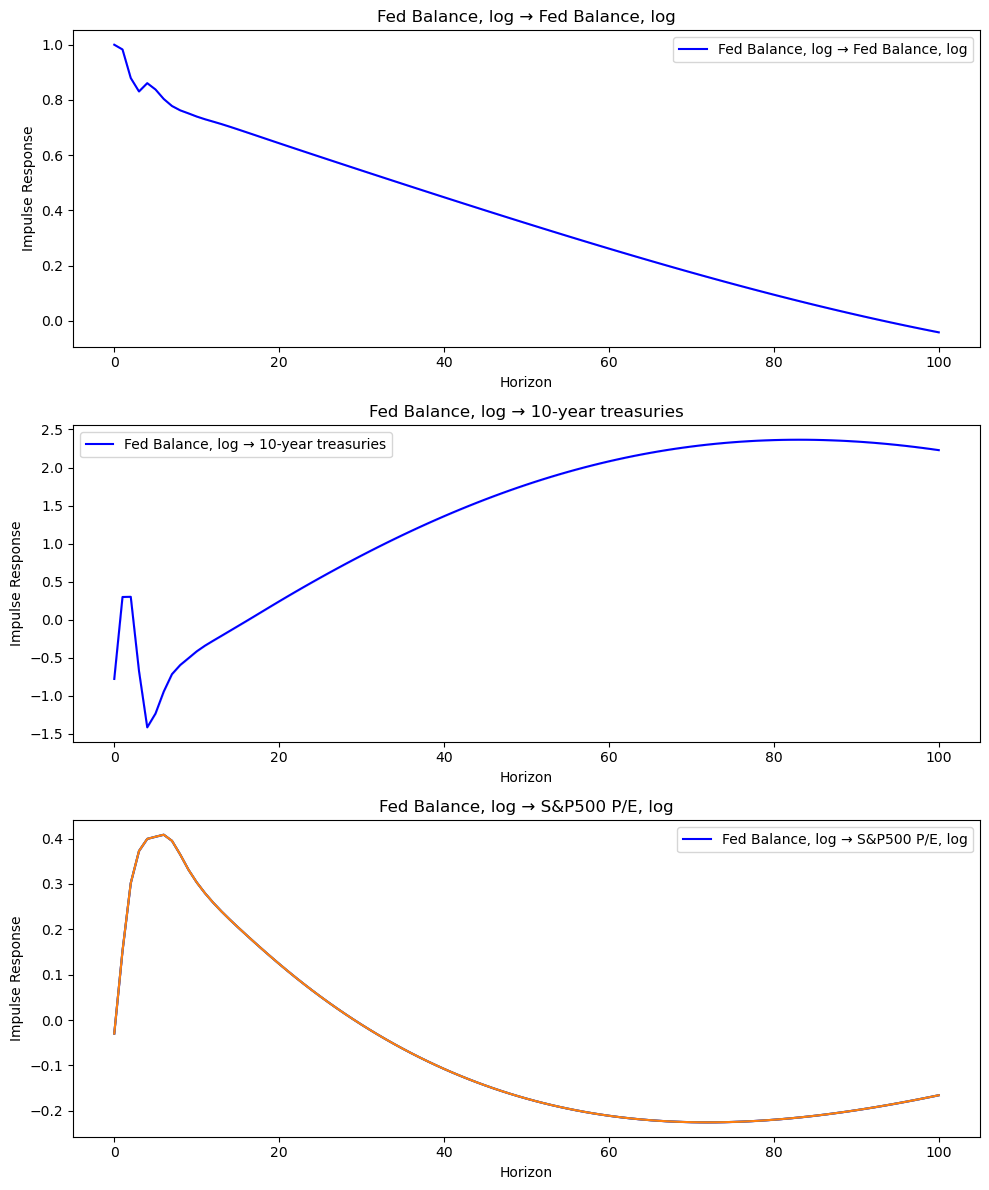

In [597]:
irf4 = resEU.irf(periods = 100)

# Standard deviation of the shock (from your IRF plot or calculations)
std_dev_shock = irf4.orth_irfs[0][0][0]  # 3.5% increase in assets corresponds to 1 std deviation

# Normalize the shock to 100% increase
normalized_shock = 1.0 / std_dev_shock  # This should give the factor to scale up the shock

# Apply the normalized shock to the IRF
irf_response = irf4.orth_irfs * normalized_shock

# Plot the normalized IRF
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].plot(irf_response[:, 0, 0], label='Fed Balance, log → Fed Balance, log', color='blue')


axes[0].fill_between(range(len(irf_response[:, 0, 0])), 
                     irf_response[:, 0, 0] - 1.96 * irf4.cov(orth=True)[:, 0, 0], 
                     irf_response[:, 0, 0] + 1.96 * irf4.cov(orth=True)[:, 0, 0], 
                     color='blue', alpha=0.1)
axes[0].set_title('Fed Balance, log → Fed Balance, log')

axes[1].plot(irf_response[:, 1, 0], label='Fed Balance, log → 10-year treasuries', color='blue')
axes[1].fill_between(range(len(irf_response[:, 1, 0])), 
                     irf_response[:, 1, 0] - 1.96 * irf4.cov(orth=True)[:, 1, 0], 
                     irf_response[:, 1, 0] + 1.96 * irf4.cov(orth=True)[:, 1, 0], 
                     color='blue', alpha=0.1)
axes[1].set_title('Fed Balance, log → 10-year treasuries')

axes[2].plot(irf_response[:, 2, 0], label='Fed Balance, log → S&P500 P/E, log', color='blue')
axes[2].plot(irf_response[:, 2, 0] - 1.96 * irf4.cov(orth=True)[:, 2, 0])
axes[2].plot(irf_response[:, 2, 0] + 1.96 * irf4.cov(orth=True)[:, 2, 0])

axes[2].fill_between(range(len(irf_response[:, 2, 0])), 
                     irf_response[:, 2, 0] - 1.96 * irf4.cov(orth=True)[:, 2, 0], 
                     irf_response[:, 2, 0] + 1.96 * irf4.cov(orth=True)[:, 2, 0], 
                     color='blue', alpha=0.1)
axes[2].set_title('Fed Balance, log → S&P500 P/E, log')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Horizon')
    ax.set_ylabel('Impulse Response')

plt.tight_layout()
plt.show()

### Stationary data:

In [599]:
VAR(rdf_EU_VAR).select_order().summary()
#VAR(rCMP).select_order().summary()
#VAR(rAPP).select_order().summary()
#VAR(rPEPP).select_order().summary()
#VAR(rQT).select_order().summary()

,AIC,BIC,FPE,HQIC
0,-20.91,-20.90*,8.271e-10,-20.91
1,-20.95,-20.90,7.946e-10,-20.93*
2,-20.96*,-20.86,7.918e-10*,-20.92
3,-20.94,-20.80,8.034e-10,-20.89
4,-20.95,-20.76,7.954e-10,-20.88
5,-20.95,-20.72,7.946e-10,-20.87
6,-20.94,-20.67,8.023e-10,-20.84
7,-20.94,-20.62,8.040e-10,-20.82
8,-20.94,-20.58,8.065e-10,-20.80
9,-20.94,-20.53,8.089e-10,-20.78


In [600]:
resEU = VAR(rdf_EU_VAR).fit(5)
#resEU = VAR(rCMP).fit(5)
#resEU = VAR(rAPP).fit(5)
#resEU = VAR(rPEPP).fit(5)
#resEU = VAR(rQT).fit(5)

In [601]:
for i in range(resEU.resid.shape[1]):
    print(df_EU_VAR.columns[i], ':')
    print(acorr_ljungbox(resEU.resid.iloc[:, i]), "\n")

ECB Balance, log :
      lb_stat  lb_pvalue
1    0.002763   0.958076
2    0.019312   0.990391
3    0.045241   0.997475
4    0.070688   0.999390
5    0.507688   0.991839
6    2.044853   0.915528
7    2.346030   0.938238
8    3.449494   0.903074
9    7.181158   0.618265
10  10.079356   0.433559 

10-year bonds :
     lb_stat  lb_pvalue
1   0.001728   0.966837
2   0.090008   0.955993
3   0.129215   0.988115
4   0.162554   0.996871
5   0.223285   0.998843
6   0.877243   0.989841
7   1.029812   0.994333
8   3.821867   0.872827
9   3.855931   0.920636
10  4.330265   0.931221 

EuroStoxx 50 P/E :
     lb_stat  lb_pvalue
1   0.002139   0.963110
2   0.002427   0.998787
3   0.002518   0.999966
4   0.003185   0.999999
5   0.006546   1.000000
6   0.639192   0.995711
7   1.978984   0.960994
8   2.840527   0.943963
9   2.865246   0.969399
10  4.743653   0.907631 



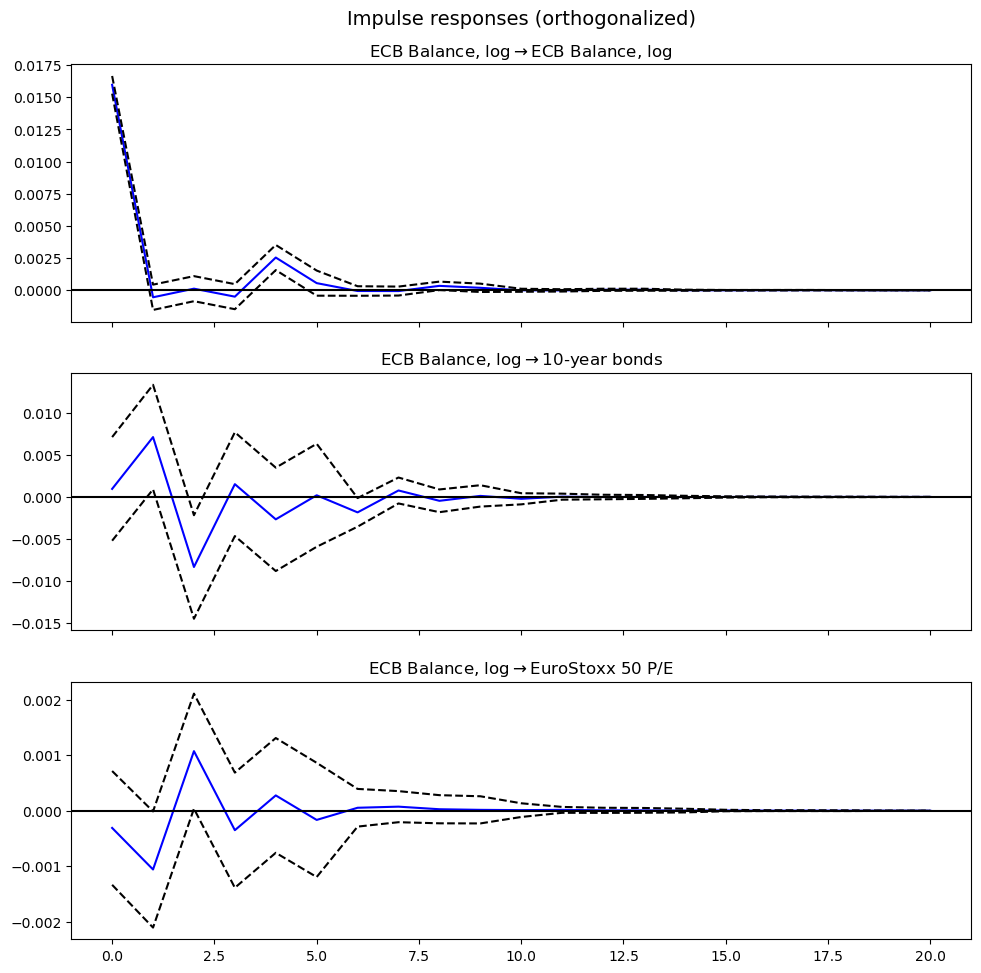

In [602]:
resEU.irf(periods = 20).plot(orth=True, impulse='ECB Balance, log');

# Local Projections

In [604]:
def local_projection(y, x, horizon):
    """
    Perform local projection for a given horizon.
    
    Parameters:
    y: Dependent variable (target).
    x: Independent variables (regressors).
    horizon: Forecast horizon.
    
    Returns:
    coefficients: Estimated coefficients for the given horizon.
    """
    
    y_shifted = y.shift(-horizon).dropna() # Shift the dependent variable by the forecast horizon
    x_aligned = sm.add_constant(x.loc[y_shifted.index]) # Align the independent variables to match the shifted dependent variable and add a constant to the regressors
    model = sm.OLS(y_shifted, x_aligned).fit() # Fit the OLS model
    
    return model.params, model.pvalues, model.bse

In [641]:
#dfSVAR = dfVAR.copy()
dfSVAR = QE123.copy()
#dfSVAR = QE4.copy()
dfSVAR['Policy Loosening'] = 0
dfSVAR['Policy Tightening'] = 0
dfSVAR = dfSVAR[['Policy Loosening', 'Policy Tightening', 'Fed Balance, log', '10-year treasuries', 'S&P500 P/E, log']]
dates_l = ['2008-11-30', '2010-09-26', '2012-08-05', '2012-09-16', '2012-12-16' ,'2020-03-15', '2020-06-14'] #dates when Fed announced purchases
dates_t = ['2009-08-16', '2011-06-26', '2013-12-22', '2021-11-07', '2021-12-19'] #dates when Fed announced BS tapering

for date in dates_l:
    if date in dfSVAR.index:  
        dfSVAR.loc[date, 'Policy Loosening'] = 1

for date in dates_t:
    if date in dfSVAR.index:  
        dfSVAR.loc[date, 'Policy Tightening'] = 1


In [649]:
#dfSVAR_EU = df_EU_VAR.copy()
#dfSVAR_EU = CMP.copy()
#dfSVAR_EU = APP.copy()
dfSVAR_EU = PEPP.copy()

dfSVAR_EU['Policy Loosening'] = 0
dfSVAR_EU['Policy Tightening'] = 0
dfSVAR_EU = dfSVAR_EU[['Policy Loosening', 'Policy Tightening', 'ECB Balance, log', '10-year bonds', 'EuroStoxx 50 P/E']]
dates_l = ['2010-05-16', '2012-07-29', '2014-12-21', '2015-10-25', '2016-03-06' ,'2020-03-15', '2020-06-07', '2020-12-13'] #dates when Fed announced purchases
dates_t = ['2016-12-11', '2017-10-29', '2018-06-17', '2021-12-19'] #dates when Fed announced BS tapering

for date in dates_l:
    if date in dfSVAR_EU.index:  
        dfSVAR_EU.loc[date, 'Policy Loosening'] = 1

for date in dates_t:
    if date in dfSVAR_EU.index:  
        dfSVAR_EU.loc[date, 'Policy Tightening'] = 1


In [653]:
#dfLP = dfSVAR.copy()
dfLP = dfSVAR_EU.copy()
#dfLP = dfLP[['S&P500 P/E, log', 'Policy Loosening','Policy Tightening']]
dfLP = dfLP[['EuroStoxx 50 P/E', 'Policy Loosening','Policy Tightening', 'ECB Balance, log', '10-year bonds']]

lag = 5
for c in dfLP.columns:
    for i in range(1, lag+1):
            dfLP[f'{c}, lag {i}'] = dfLP[c].shift(i)
        
dfLP.dropna(inplace=True)

In [655]:
y = dfLP.iloc[:,0]
x = dfLP.drop(columns=dfLP.columns[0]) #same results as in the complete specification



max_horizon = 100
lp_results = {}
lp_pvalues = {}
lp_SEvalues = {}

for horizon in range(1, max_horizon + 1):
    lp_results[horizon] = local_projection(y, x, horizon)[0]
    lp_pvalues[horizon] = local_projection(y, x, horizon)[1]
    lp_SEvalues[horizon] = local_projection(y, x, horizon)[2]

lp_results = pd.DataFrame(lp_results).T
lp_pvalues = pd.DataFrame(lp_pvalues).T 
lp_SEvalues = pd.DataFrame(lp_SEvalues).T 

for i in lp_pvalues.columns:
    lp_pvalues.rename(columns = {i:f'{i}, p-value'}, inplace = True)
    
LP = pd.DataFrame(index = lp_results.index)
for i in range(lp_results.shape[1]):
    LP = pd.concat([LP, lp_results.iloc[:,i],lp_pvalues.iloc[:,i]], axis = 1)


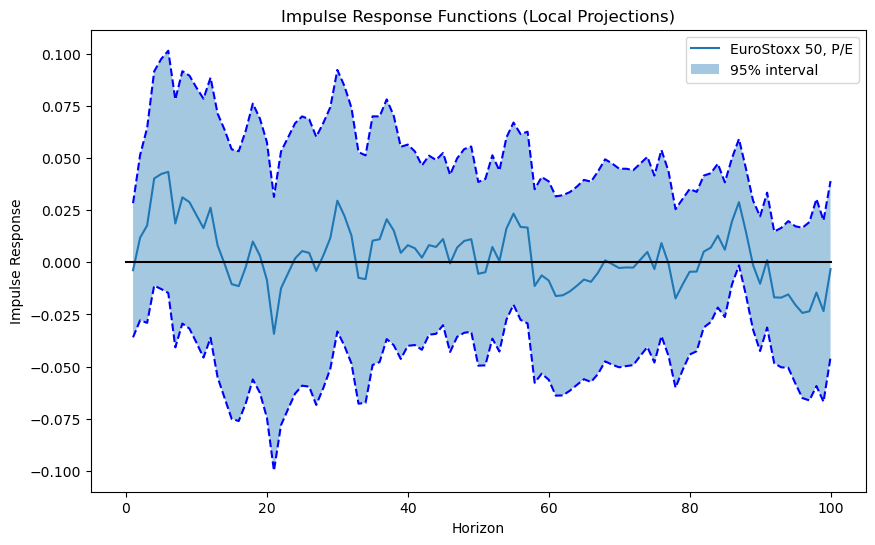

In [659]:
plt.figure(figsize=(10, 6))
plt.plot(lp_results.index, lp_results.iloc[:,1], label =  "EuroStoxx 50, P/E")

plt.xlabel('Horizon')
plt.ylabel('Impulse Response')
plt.title('Impulse Response Functions (Local Projections)')

upper = lp_results.iloc[:,1] + lp_SEvalues.iloc[:,1]*2
upper.plot(color='blue', linestyle='--',label='_nolegend_')

lower = lp_results.iloc[:,1] - lp_SEvalues.iloc[:,1]*2
lower.plot(color='blue', linestyle='--',label='_nolegend_')

plt.fill_between(lp_results.index, lower, upper, alpha=0.4, label="95% interval")
plt.plot(np.linspace(0,100,100), np.zeros(100), color = 'black')
plt.legend()
plt.savefig('robust EU PEPP')
plt.show();

# Robustness checks

In [ ]:
FF = web.DataReader('FEDFUNDS', 'fred', start - datetime.timedelta(days = 366) , end).resample('M').last()
Unempl = web.DataReader('UNRATE', 'fred', start - datetime.timedelta(days = 366) , end).resample('M').last()
SP500 = FactSet.loc[:,'Price']
SP500_log = np.log(SP500) 
Vol_log =  np.log(FactSet.loc[:, 'CVol'])
Unempl = np.log(web.DataReader('CCSA', 'fred', start - datetime.timedelta(days = 366) , end).resample('W').last())
BanksIndex = pd.read_excel("C:\\Users\\Asus\\Downloads\\PriceHistoryBanks.xlsx", header = 2)[1:].set_index('Date').resample('M').mean().loc[:,'Price']
USp = web.DataReader('INDPRO', 'fred', start - datetime.timedelta(days = 366) , end)
USp = (USp['INDPRO'].pct_change(1)).dropna().resample('M').last()*100  
cpi_us = web.DataReader('CPIAUCSL', 'fred', start - datetime.timedelta(days = 366) , end)
CPI = (cpi_us['CPIAUCSL'].pct_change(1)).dropna().resample('M').last()*100  # Calculate the YoY change
nasdaq =  web.DataReader('NASDAQCOM', 'fred', start , end).resample('W').last()
nasdaq =  yf.download('^GSPC', start=start, end=end)['Adj Close'].resample('W').last()

In [ ]:
'''
#df['S&P500 P/E, log'] = np.log(PE) 
df['CPI, mom %'] = CPI
df['S&P500 volume, log'] = Vol_log

df['Industrial production, % yoy'] = USp
df['Dow Jones U.S. Banks Index, log'] = np.log(BanksIndex)
df['Unemployment'] = Unempl
df['NASDAQ'] = np.log(nasdaq)
df['Federal funds rate'] = FF
#df = df.dropna()
'''

In [ ]:
dates_l = ['2008-11-30', '2010-10-31', '2012-08-30', '2020-03-31'] #dates when Fed started ramping up the balance sheet
dates_t = ['2017-09-30', '2022-05-31'] #dates when Fed announced BS reduction

# Other 

In [ ]:

url = 'https://www.multpl.com/s-p-500-pe-ratio/table/by-month'
response = requests.get(url).text
soup = BeautifulSoup(response, 'lxml')
table = soup.select_one('.tcol')
pandas_table = pd.read_html(str(table))
pandas_table = pandas_table[0]

pandas_table['Date'] = pd.to_datetime(pandas_table['Date'], format='%b %d, %Y')


def clean_value(value):
    # Remove special characters using a regular expression
    cleaned_value = re.sub(r'[^\d.-]', '', value)  # Keeps digits, dots, and negative signs

    return cleaned_value

# Apply the cleaning function to the "Value" column
pandas_table['Value'] = pandas_table['Value'].apply(clean_value)
pandas_table['Value'] = pd.to_numeric(pandas_table['Value'], errors='coerce')
PtoE = pandas_table.set_index('Date')
PtoE = PtoE[::-1].resample('M').last()
PtoE.plot()
dfVAR['S&P500 P/E, log'].plot()

IRF: 

In [ ]:
short = df.loc['2007-01-01':]

x = short.index
data1 = short['Fed Balance, log']
data2 = short['S&P500 P/E']

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(x, data1, color = 'r', label = 'Fed BS') 
ax1.set_ylabel('$ tr')
plt.legend()
ax2 = ax1.twinx() 
ax2.plot(x, data2, label = 'SP500, PE')

plt.legend()
plt.show()